<a href="https://colab.research.google.com/github/sansaldo/MapSy/blob/main/MapSy_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# May need to install pathfinding for above block to run
!pip install pathfinding

In [ ]:
#Load Modules

%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy
from google.colab.patches import cv2_imshow
from skimage import segmentation
from skimage import io, color
import skimage
import PIL
import math
import matplotlib.image as mpimg
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import IPython
from __future__ import print_function
import os
import sys
import tarfile
from IPython.display import display, Image
import h5py
from PIL import Image
import random
from urllib.request import urlretrieve
from collections import Counter
from pathfinding.core.diagonal_movement import DiagonalMovement
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder
from pathfinding.finder.bi_a_star import BiAStarFinder
import copy

In [ ]:
# Load images
! wget -O map1.png "https://drive.google.com/uc?export=download&id=1jEhHqi9SMyL8JV9eUtnXWQ7lKfjm4ybU"
! wget -O map2.png "https://drive.google.com/uc?export=download&id=1LPhZF68x0XsqHvd37nWpVLF2VHlKU6br"
! wget -O map3.png "https://drive.google.com/uc?export=download&id=1ubbgc1h3aKV4Xl3upg9k590UrXOWCWDu"
! wget -O map4.png "https://drive.google.com/uc?export=download&id=12ENtQ4ryifWkFngSmvMbabNnJA4_Wk4o"

--2020-12-05 16:03:21--  https://drive.google.com/uc?export=download&id=1jEhHqi9SMyL8JV9eUtnXWQ7lKfjm4ybU
Resolving drive.google.com (drive.google.com)... 172.217.214.138, 172.217.214.113, 172.217.214.102, ...
Connecting to drive.google.com (drive.google.com)|172.217.214.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-30-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o65jmspra87p14ucnhmukkqui2b5d6mm/1607184150000/13322879393448623306/*/1jEhHqi9SMyL8JV9eUtnXWQ7lKfjm4ybU?e=download [following]
--2020-12-05 16:03:21--  https://doc-0s-30-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o65jmspra87p14ucnhmukkqui2b5d6mm/1607184150000/13322879393448623306/*/1jEhHqi9SMyL8JV9eUtnXWQ7lKfjm4ybU?e=download
Resolving doc-0s-30-docs.googleusercontent.com (doc-0s-30-docs.googleusercontent.com)... 108.177.111.132, 2607:f8b0:4001:c07::84
Connecting to doc-0s-30-docs.googleusercontent.com (d

In [ ]:
# Convert Maps
map1 = cv2.imread("map1.png")
map1 = cv2.cvtColor(map1, cv2.COLOR_BGR2RGB)
map2 = cv2.imread("map2.png")
map2 = cv2.cvtColor(map2, cv2.COLOR_BGR2RGB)
map3 = cv2.imread("map3.png")
map3 = cv2.cvtColor(map3, cv2.COLOR_BGR2RGB)
map4 = cv2.imread("map4.png")
map4 = cv2.cvtColor(map4, cv2.COLOR_BGR2RGB)

maps = [map1, map2, map3, map4]

In [ ]:
print(map1.shape)
print(map2.shape)
print(map3.shape)
print(map4.shape)

(353, 617, 3)
(550, 600, 3)
(804, 835, 3)
(506, 821, 3)


In [ ]:
IPython.display.HTML('./point_tracker.html')

In [ ]:
# Line Functions
def recPathFollowCol(map, ref, point, minnormOG):
  h, w, c = map.shape
  color = map[point[0], point[1], :]
  minnorm = minnormOG
  minpt = [0,0]
  box = 3
  for i in range(box):
    i = int(i - (box-1)/2)
    for j in range(box):
      j = int(j - (box-1)/2)
      if (point[0]+i >= 0) & (point[1]+j >= 0) & (point[0]+i < h) & (point[1]+j < w):
        if (np.count_nonzero(map[point[0]+i, point[1]+j, :]) == 0) & (not np.array_equal(ref[point[0]+i, point[1]+j, :], np.array([255,255,255]))) & (ref[point[0]+i, point[1]+j, :][1] < 230):
          n = np.linalg.norm(ref[point[0]+i, point[1]+j,:]-color)
          if n < minnorm:
            minpt = [point[0] + i, point[1] + j]
            minnorm = n
  if minnorm < minnormOG:
    map[minpt[0] , minpt[1], :] = ref[minpt[0] , minpt[1], :]
    #map = recPathFollowCol(map, ref, minpt)
  return map

def pullContours(map, color, itrs, minnorm=30):
  h,w,c = map.shape
  mod = np.array([2,2,2])
  color = np.array(color)
  mask = cv2.inRange(map, np.array(color-mod), np.array(color+mod))
  targets = cv2.bitwise_and(map,map, mask=(mask))
  #plt.figure(figsize = (20,20))
  #plt.imshow(targets)
  #End phase 1

  unique = np.array([color, color])
  newid = 2
  mask = cv2.inRange(map, color-mod, color+mod)
  ptargets = np.zeros(targets.shape)
  targets2 = targets.copy()

  for f in range(itrs):
    for i in range(h):
      for j in range(w):
        cont = False
        if (np.count_nonzero(targets2[i,j,:]) > 0) and (np.count_nonzero(ptargets[i,j,:]) == 0):
          for c in range(unique.shape[0]):
            if np.array_equal(targets2[i,j,:], unique[c,:]):
              cont = True
          if not cont:
            unique = np.vstack((unique, targets2[i,j,:]))
            mask = mask | cv2.inRange(map, np.array(unique[c,:]-mod), np.array(unique[c,:]+mod))
      
    newid = unique.shape[0]-1
    ptargets = targets2.copy()
    targets2 = cv2.bitwise_and(map,map, mask=(mask))
    print(f, unique.shape)
    for i in range(h):
      for j in range(w):
        if np.count_nonzero(targets2[i,j,:]) > 0:
          targets2[i,j,:] = map[i,j,:]
          targets2 = recPathFollowCol(targets2, map, [i,j],minnorm)

  #plt.imshow(targets2)
  #End phase 2
  return targets2 

def expandLines(map, itrs):
  h,w,c = map.shape
  box = 3
  red = 255
  pred = 255
  newmap = map.copy()
  temp = map.copy()
  for i in range(h):
      for j in range(w):
        if np.count_nonzero(temp[i,j,:]) > 0:
          for a in range(box):
              a = int(a - (box-1)/2)
              for b in range(box):
                b = int(b - (box-1)/2)
                if (i+a >= 0) & (j+b >= 0) & (i+a < h) & (j+b < w):
                  if np.count_nonzero(newmap[i+a,j+b,:]) == 0:
                    newmap[i+a,j+b,0] = red

  for f in range(itrs):
    print(f)
    pred = red
    red = red - int(255/itrs)
    temp = newmap.copy()
    for i in range(h):
      for j in range(w):
        if temp[i,j,0] == pred:
          for a in range(box):
              a = int(a - (box-1)/2)
              for b in range(box):
                b = int(b - (box-1)/2)
                if (i+a >= 0) & (j+b >= 0) & (i+a < h) & (j+b < w):
                  if np.count_nonzero(newmap[i+a,j+b,:]) == 0:
                    newmap[i+a,j+b,0] = red
                    #newmap[i+a,j+b,1] = red
                    #newmap[i+a,j+b,2] = red
  return newmap 

In [ ]:
# Segmentation Functions
def label2rgb(labels):
  """
  Convert a labels image to an rgb image using a matplotlib colormap
  """
  label_range = np.linspace(0, 1, 256)
  lut = np.uint8(plt.cm.viridis(label_range)[:,2::-1]*256).reshape(256, 1, 3) # replace viridis with a matplotlib colormap of your choice
  return cv2.LUT(cv2.merge((labels, labels, labels)), lut)

def cluster_centers(superpixel_map):
  """ This function takes a superpixel map and returns a list with the 
  (row,col) positions of the cluster centers for that map"""

  x_centers = np.zeros(len(np.unique(superpixel_map)))
  y_centers = np.zeros_like(x_centers)
  counts = np.zeros_like(x_centers)
  rows, cols = superpixel_map.shape

  for row in range(rows):
    for col in range(cols):
      x_centers[superpixel_map[row, col]] += col
      y_centers[superpixel_map[row, col]] += row
      counts[superpixel_map[row, col]] += 1

  x_centers = np.round(x_centers/counts).astype('int')
  y_centers = np.round(y_centers/counts).astype('int')
  centers = list(zip(y_centers, x_centers))
  return centers

def apply_supermap(img, superpixel_map):
  """ This function returns an image where we assign the color of the cluster centers 
  to every pixel of their corresponding segmentation groups."""
  centers = cluster_centers(superpixel_map)
  out = np.zeros_like(img)
  for i,(row, col) in enumerate(centers):
    out[superpixel_map == i] = img[row, col]
  return out

def apply_supermap_ave(img, superpixel_map):
  """ This function returns an image where we assign the color of the cluster centers 
  to every pixel of their corresponding segmentation groups."""
  centers = cluster_centers(superpixel_map)
  out = np.zeros_like(img)
  for i,(row, col) in enumerate(centers):
    out[superpixel_map == i] = np.average(img[superpixel_map == i], axis = 0)
  return out

def loc2color(img, loc, box = 2):
  x, y = loc
  r = np.average(img[x-box:x+box+1, y-box:y+box+1, 0])
  g = np.average(img[x-box:x+box+1, y-box:y+box+1, 1])
  b = np.average(img[x-box:x+box+1, y-box:y+box+1, 2])
  return (r, g, b)

def colorClassify(img, superpixel_map, colors, costs=[]):
  r,c = colors.shape
  if (len(costs) == 0):
    costs = np.ones((r,1))
  out = np.zeros_like(img)
  cost_map = np.zeros_like(superpixel_map)
  superpixel_count = np.max(superpixel_map)+1
  for i in range(superpixel_count):
    pixel_color = np.average(img[superpixel_map == i], axis = 0)
    dist_2 = np.sum((colors - pixel_color)**2, axis = 1)
    best = np.argmin(dist_2)
    out[superpixel_map == i] = colors[best]
    cost_map[superpixel_map == i] = costs[best]
  return out, cost_map

def blurMap(img, b = 5, m = 5):
  out = cv2.blur(img, (b,b))
  out = cv2.medianBlur(out,m)
  return out

def superPixelsSeg(img, desSuperSize=10, compact=10, max_iter=50):
  [x, y, z] = img.shape
  segs = int(x*y/(desSuperSize*desSuperSize))
  super = segmentation.slic(img, n_segments=segs, compactness=10, max_iter=50)
  super_ave = apply_supermap_ave(img, super)
  return [super, super_ave]

In [ ]:
# Perform Line Functions on maps for contours, paths, and purple
map = map4

map_contours = pullContours(map, [197, 121, 58], 5, 15)
map_purple = pullContours(map, [178, 0, 254], 4, 30)
map_roads =  pullContours(map, [24, 23, 23], 4, 30)

0 (3, 3)
1 (36, 3)
2 (176, 3)
3 (438, 3)
4 (689, 3)
0 (4, 3)
1 (28, 3)
2 (86, 3)
3 (162, 3)
0 (2, 3)
1 (71, 3)
2 (231, 3)
3 (468, 3)


0
0
0


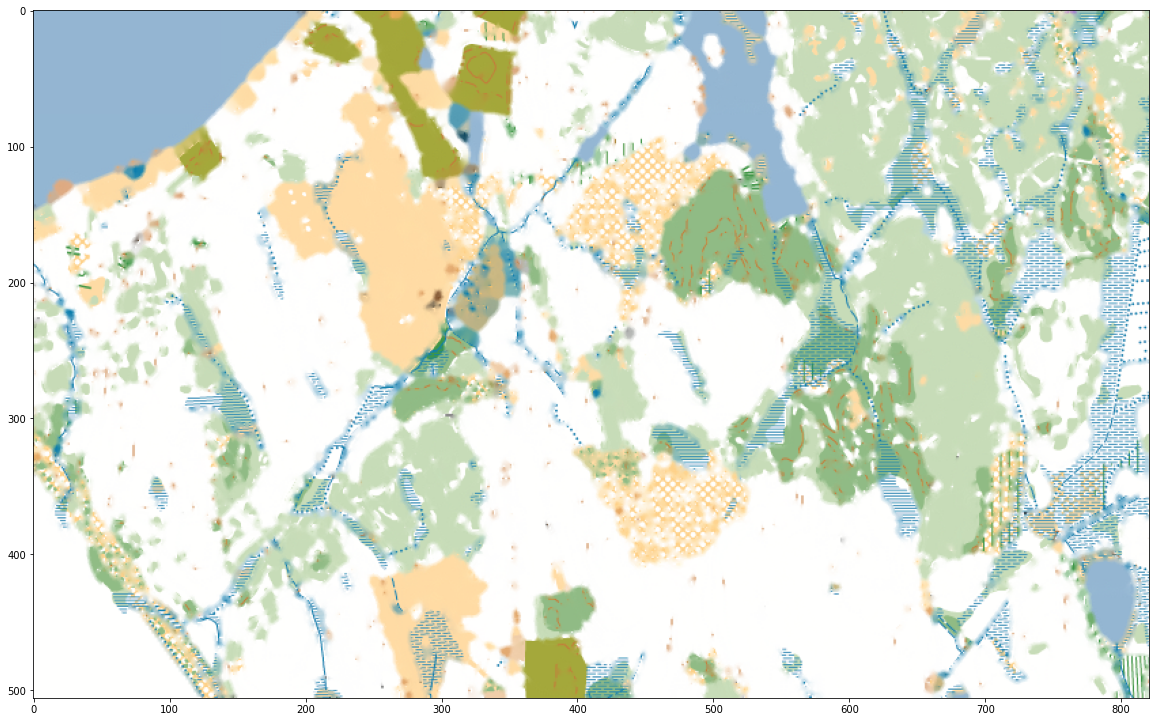

In [ ]:
map_contours_e = expandLines(map_contours,1)
map_purple_e = expandLines(map_purple,1)
map_roads_e = expandLines(map_roads,1)
map_contours_e_gray = cv2.cvtColor(map_contours_e, cv2.COLOR_RGB2GRAY)
map_purple_e_gray = cv2.cvtColor(map_purple_e, cv2.COLOR_RGB2GRAY)
map_roads_e_gray = cv2.cvtColor(map_roads_e, cv2.COLOR_RGB2GRAY)
map_mask = (map_contours_e_gray + map_purple_e_gray + map_roads_e_gray) > 0
map_clean = cv2.inpaint(map,np.uint8(map_mask*1),3,cv2.INPAINT_TELEA)
plt.figure(figsize=(20,20))
plt.imshow(map_clean)

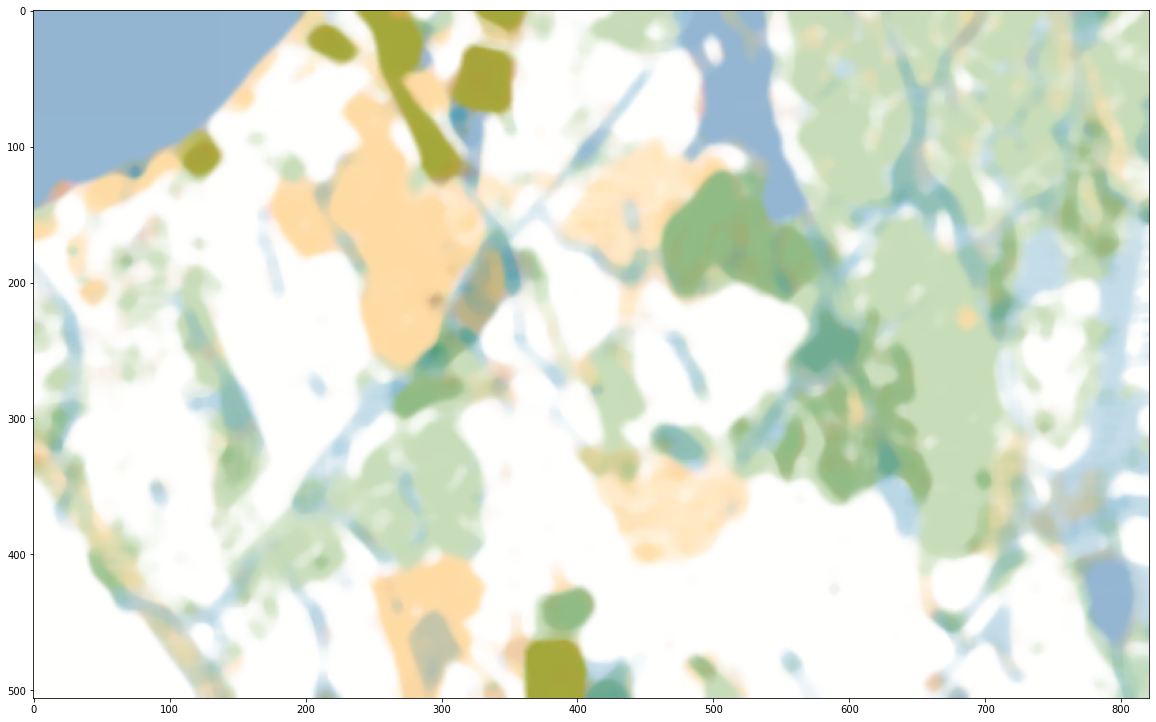

In [ ]:
map_blurred = blurMap(map_clean, b = 5, m = 13)
plt.figure(figsize=(20,20))
plt.imshow(map_blurred)

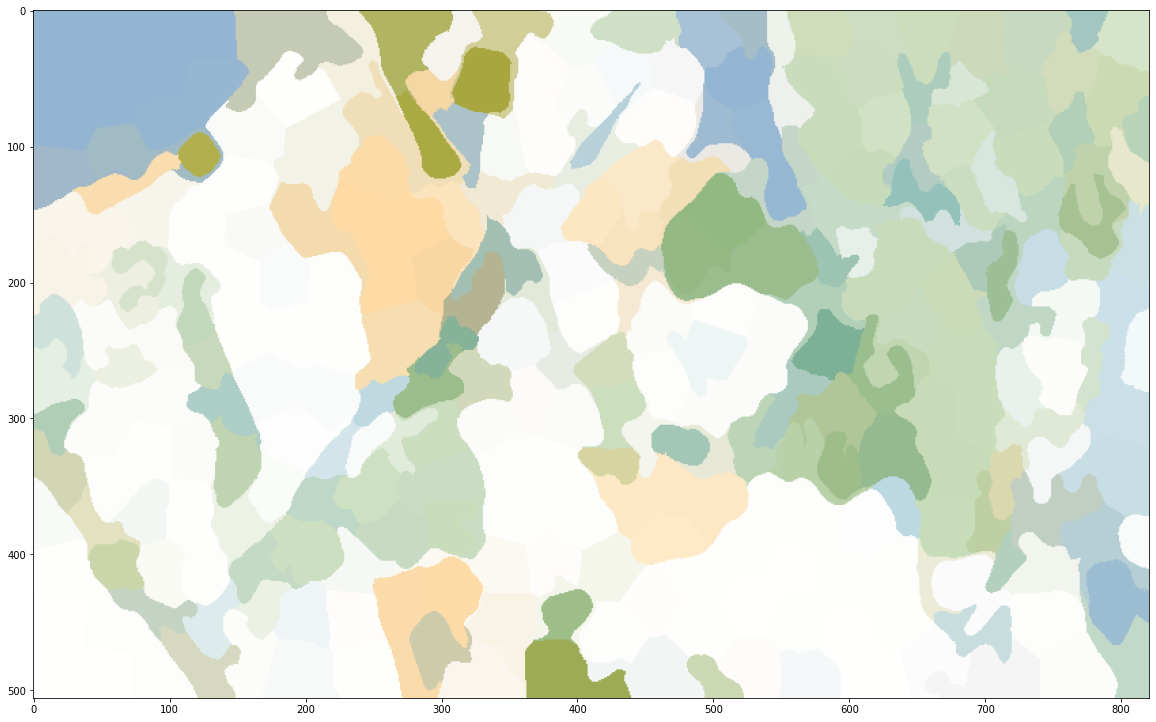

In [ ]:
map_super, map_super_ave = superPixelsSeg(map_blurred, desSuperSize=35, compact=10)
plt.figure(figsize=(20,20))
plt.imshow(map_super_ave)

In [ ]:
locs = [(149,504), (121,449),(45,48), (166,257), (32,271), (262,679), (189,744), (319,478)]
map_costs = np.array([5,1.5,0,1.25,5,10,5,5])
map_colors = []
for i in range(len(locs)):
  map_colors.append(loc2color(map_blurred, locs[i], box=3))

map_colors = np.array(map_colors)

#map_colors = np.array([[188,210,191],[73,170,225],[188,210,190],[203,233,177],[252,249,245],[249,234,200],[188,221,230]]) For map 3
# Its hards to give costs after the fact lmao
map_classified, map_terrian_cost = colorClassify(map_blurred, map_super, map_colors, map_costs)

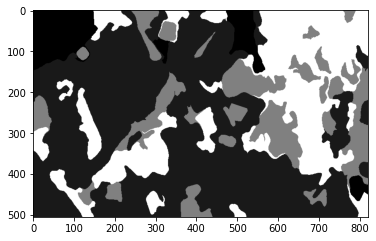

In [ ]:
plt.imshow(map_terrian_cost, cmap='gray')

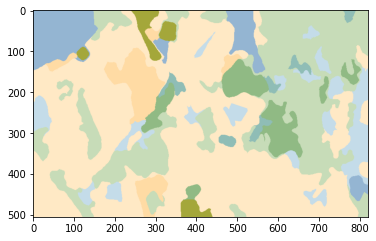

In [ ]:
plt.imshow(map_classified)

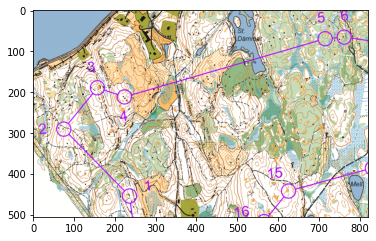

In [ ]:
plt.imshow(map)

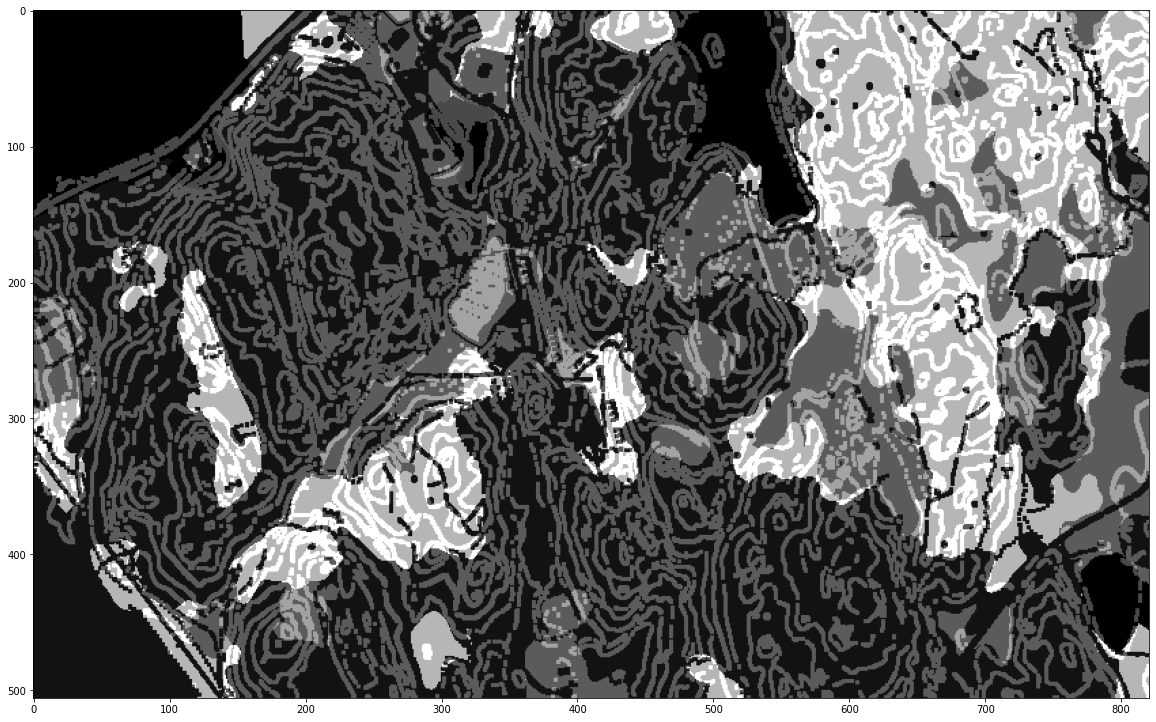

In [ ]:
map_cont_cost = (map_contours_e_gray>0)*4
map_cost = copy.deepcopy(map_terrian_cost)
map_cost[map_roads_e_gray > 0] = 1
water_mask = np.uint8((map_terrian_cost == 0)*1)
water_mask_grow = cv2.dilate(water_mask, cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3)), iterations=5)
map_cost[water_mask_grow == 1] = 0
map_cost = map_cost + map_cont_cost
plt.figure(figsize=(20,20))
plt.imshow(map_cost, cmap='gray')

In [ ]:
map_grid = Grid(matrix=map_cost)
points = [(235, 453), (76, 291), (157, 192), (223, 213), (715, 71), (763, 69)]
paths = []
for i in range(len(points)-1):
  map_grid.cleanup()
  start = map_grid.node(points[i][0],points[i][1]) 
  end = map_grid.node(points[i+1][0],points[i+1][1])
  finder = AStarFinder(diagonal_movement=DiagonalMovement.always)
  map_path, map_runs = finder.find_path(start, end, map_grid)
  print('operations:', map_runs, 'path length:', len(map_path))
  paths.append(map_path)

operations: 17860 path length: 248
operations: 8068 path length: 160
operations: 594 path length: 74
operations: 386231 path length: 932
operations: 3810 path length: 50


In [ ]:
map_route = np.zeros_like(map)
for path in paths:
  for x,y in path:
    map_route[y,x,:] = [255,255,255]
map_route_e = expandLines(map_route,1)
map_route_e_gray = cv2.cvtColor(map_route_e, cv2.COLOR_RGB2GRAY)

0


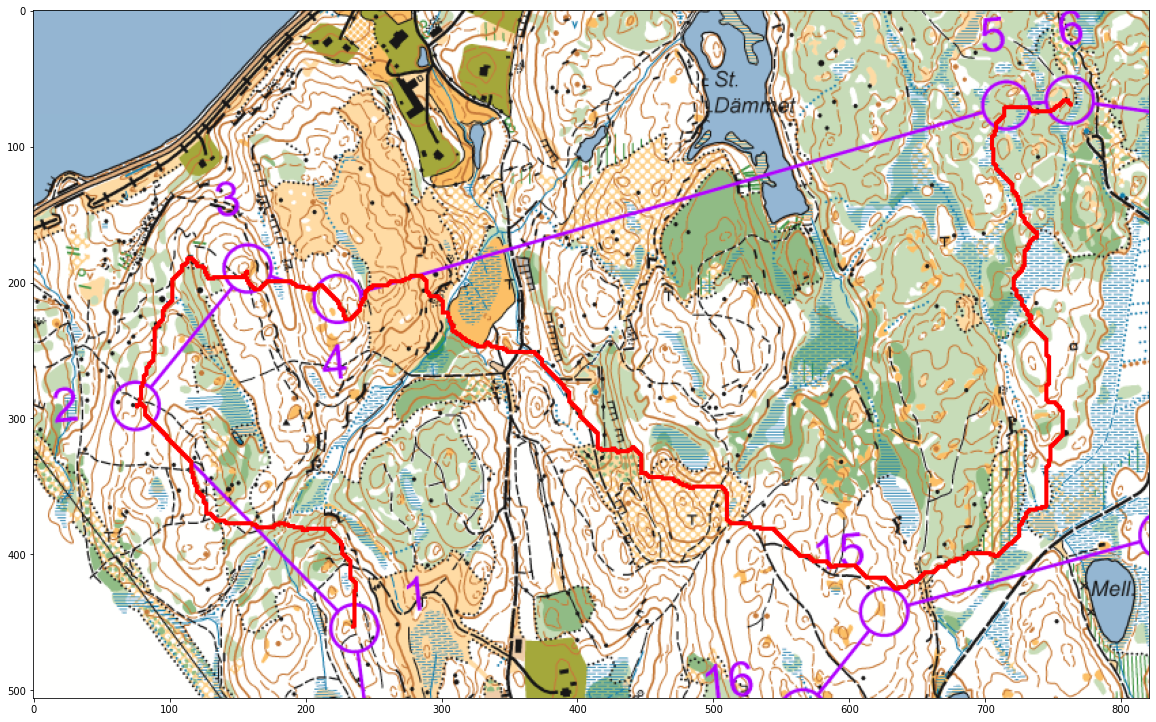

In [ ]:
map_opt = copy.deepcopy(map)
map_opt[map_route_e_gray>0] = [255,0,0]
plt.figure(figsize=(20,20))
plt.imshow(map_opt)